  Credit card fraud detection 

# Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

### Acknowledgements

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

# EDA

In [1]:
# Imported Libraries

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report


from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
sns.set(style='whitegrid', palette='inferno', font_scale=1.5)

In [2]:
data = pd.read_csv('data/creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Checking the target classes

% of normal transaction       : 99.82725143693798
Number of normal transaction   : 284315
% of fraud transaction        : 0.1727485630620034
Number of fraud transaction    : 492


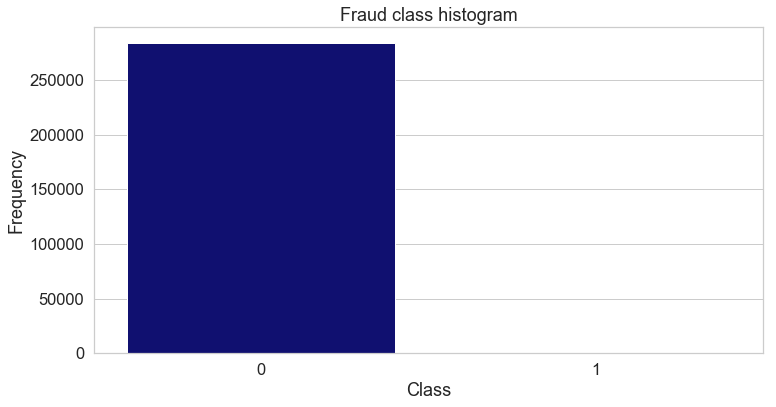

In [4]:
count_classes = pd.value_counts(data['Class'], sort=True).sort_index()
my_pal = {0: 'navy', 1: 'red'}

plt.figure(figsize=(12, 6))
ax = sns.countplot('Class', data=data, palette=my_pal)
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

# get class distribution
Count_Normal_transaction = len(data[data["Class"]==0]) # normal transaction are repersented by 0
Count_Fraud_transaction = len(data[data["Class"]==1]) # fraud by 1

Percentage_of_Count_Normal_transaction = Count_Normal_transaction / \
    (Count_Normal_transaction+Count_Fraud_transaction)
print('% of normal transaction       :', Percentage_of_Count_Normal_transaction*100)
print('Number of normal transaction   :', Count_Normal_transaction)
Percentage_of_Fraud_transaction = Count_Fraud_transaction / \
    (Count_Normal_transaction+Count_Fraud_transaction)
print('% of fraud transaction        :', Percentage_of_Fraud_transaction*100)
print('Number of fraud transaction    :', Count_Fraud_transaction)

We can see that the data is totally unbalanced! There is only 0.17 % are the fraud transcation while 99.83 are valid transcation. 

This is an example where using a typical accuracy score to evaluate our classification algorithm would be incorrect. For example, if we just used a majority class to assign values to all records, we will still be 
having a high accuracy, BUT WE WOULD BE CLASSIFYING ALL "1" INCORRECTLY!!

There are several ways to approach this unbalanced classification problem-
- Collect more data? Nice strategy but not applicable in this case
- Changing the performance metric:
 - Use the confusion matrix to calculate Precision, Recall
 - F1 score (weighted average of precision recall)
 - Use Kappa - which is a classification accuracy normalized by the imbalance of the classes in the data
 - ROC curves - calculates sensitivity/specificity ratio.

- Resampling the dataset
 - Essentially this is a method that will process the data to have an approximate 50-50 ratio.
 - One way to achieve this is by OVER-sampling, which is adding copies of the under-represented class (better when you have little data)
 - Another is UNDER-sampling, which deletes instances from the over-represented class (better when he have lot's of data)
 
Before doing resampling lets have look at the amount related to valid transcation and fraud transcation

Text(0, 0.5, 'Amount')

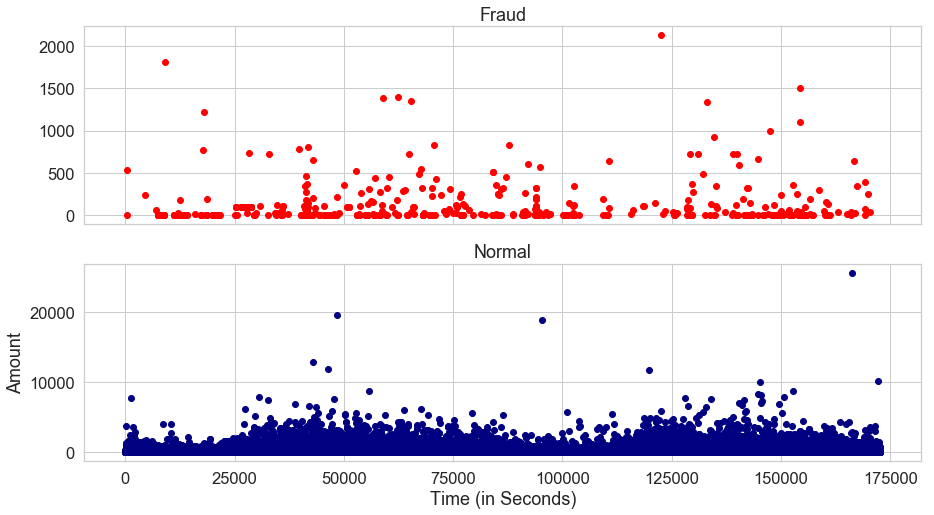

In [5]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))

ax1.scatter(data.Time[data.Class == 1],
            data.Amount[data.Class == 1], color='red')
ax1.set_title('Fraud')

ax2.scatter(data.Time[data.Class == 0],
            data.Amount[data.Class == 0],  color='navy')
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')

**The above graph shows that Time is irrelevent for detecting fraudulent transactions**

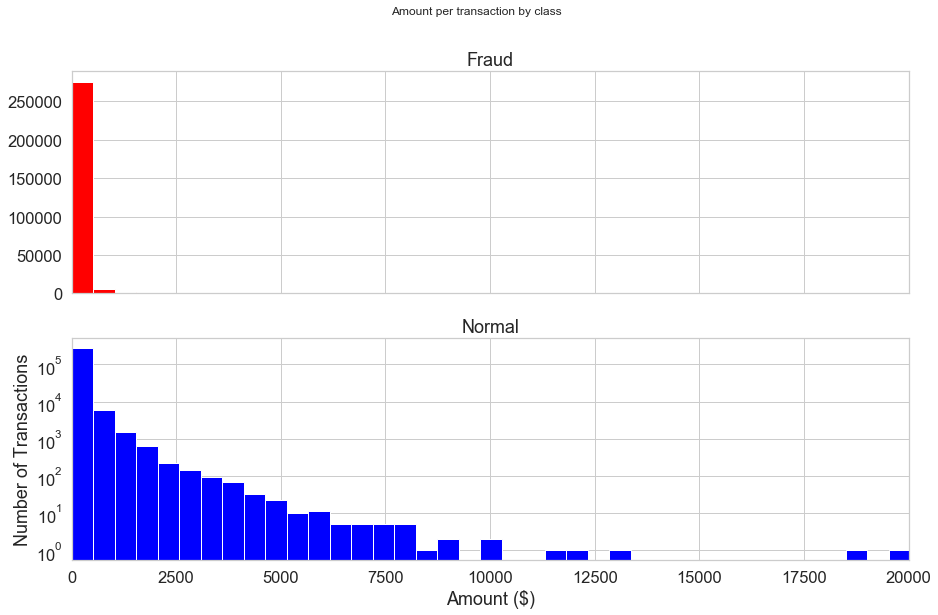

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,9))
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(data[data['Class']==0].Amount, bins = bins, color='red')
ax1.set_title('Fraud')

ax2.hist(data[data['Class']==0].Amount, bins = bins, color='blue')
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

**The above graph shows that most of the fraudulent transactions are of very low amount.**

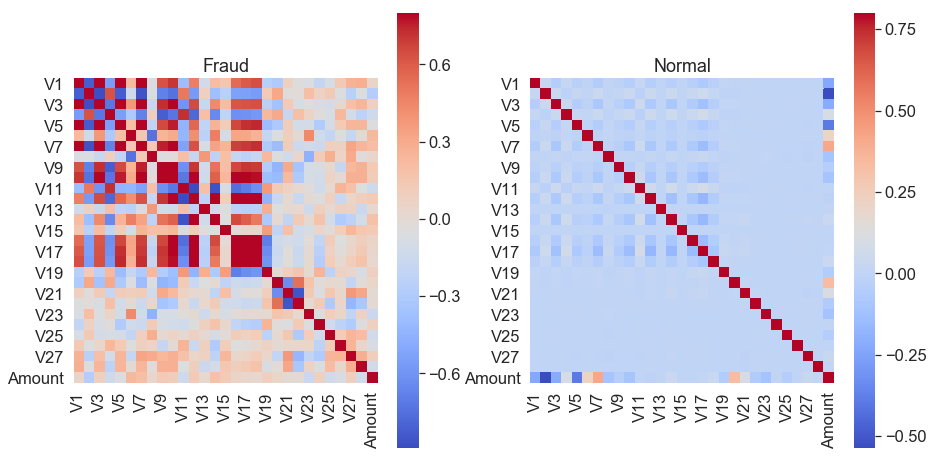

In [7]:
# correlation matrix
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

sns.heatmap(data.query('Class==1').drop(['Class', 'Time'], 1).corr(
), vmax=.8, square=True, ax=ax1, cmap='coolwarm')
ax1.set_title('Fraud')

sns.heatmap(data.query('Class==0').drop(['Class', 'Time'], 1).corr(
), vmax=.8, square=True, ax=ax2, cmap='coolwarm')
ax2.set_title('Normal')

plt.show()

In [8]:
data.isnull().any().sum()

0

**No data point is missing here**

# <a id='3'> Data preparation</a>

In [24]:
from sklearn.preprocessing import StandardScaler
data['Normalized Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

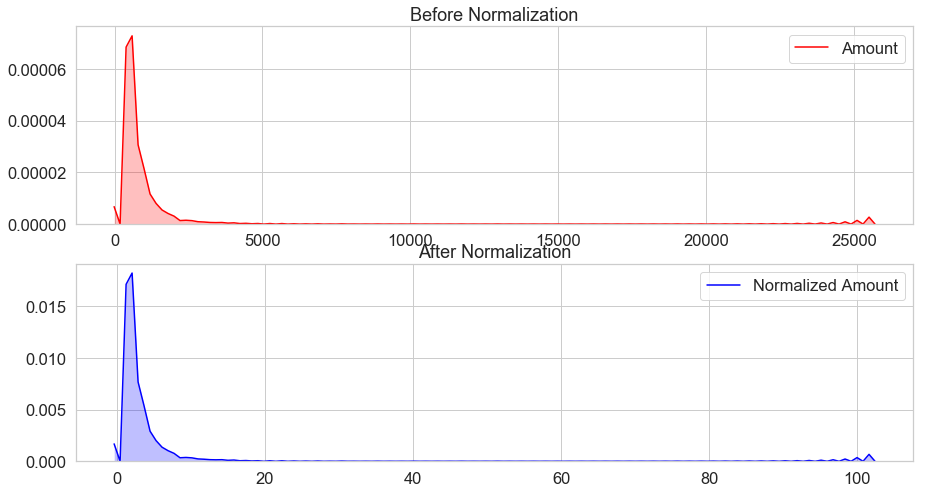

In [25]:
f, (ax1, ax2) = plt.subplots(2,1,figsize =( 15, 8))

sns.kdeplot(data['Amount'],shade=True, ax = ax1, color='red')
ax1.set_title('Before Normalization')

sns.kdeplot(data['Normalized Amount'],shade=True, ax = ax2, color='blue')
ax2.set_title('After Normalization')

plt.show()

In [44]:
# Drop useless variables
data = data.drop('Time',axis=1)

In [45]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## <a id='3.1'>3.1. Cut dataset</a>

one for train and test (skf) = 90%, other for validation = 10%

In [25]:
# Cut in 2 datasets, one for training & test, other for validation
from sklearn.model_selection import train_test_split
x = data.drop(["Class"], axis = 1)
y = data["Class"]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 101)

## <a id='#3.2'>3.2. Normalization Amount</a>

![](https://image.noelshack.com/fichiers/2018/20/5/1526651303-normalization.png)
source : https://www.slideshare.net/DhianaDevaRocha/qcon-rio-machine-learning-for-everyone

## <a id='3.3'>3.3. Drop useless variables</a>

# <a id='4'>4. Define metrics</a>



Imbalanced Data
Here we now find the core problem of our data set. The classes are extremely imbalanced. As a result, we would achieve an accuracy of 99% if we only guess that there is no fraud. But that wouldn't add value and we wouldn't need a model.

If we look at this in a logistic regression and a random forest model, you can see that the accuracy would be really good. Therefore I still use the ROC-AUC values as well as Precision/Recall/F-Score and draw a confusion matrix.

Confusionmatrix

The Confusion Matrix tells us how many True Positive, False Positive, False Negative and True Negative we have (from left to right and top to bottom).

![](https://image.noelshack.com/fichiers/2018/20/5/1526651367-qcon-rio-machine-learning-for-everyone-51-638-1.jpg)
source : https://www.slideshare.net/DhianaDevaRocha/qcon-rio-machine-learning-for-everyone


ROC-AUC

ROC-AUC-Score is a quality criterion for our model that tells us how well the model can separate between the two expressions.

Precision

Precision tells us how many elements have been correctly assigned in relation to the false positives. If we have a low Precision this speaks for many False Positives.False positives in this case would be values that were classified as fraud but are not. In the real world this would increase our staff costs. It could also reduce customer satisfaction if payments were frozen for no reason.

Precison = TP/(TP+FP)



Recall

Recall, on the other hand, refers to the false negatives and indicates our accuracy in the reference. A high recall thus speaks for a model that has few false negatives. We would like to prevent false negatives in this case most likely. These would be cases of fraud that are classified as "no fraud". Therefore we look further to find a model that has as high a recall as possible, but does not cause unnecessary costs by generating too many false positives.


Recall = TP/(TP+FN)


f1-Score
This value expresses the precision and the recall in one value and can generally be interpreted as model quality.



In [26]:
def plot_roc():
    plt.plot(roc_curve(y_test, pred)[0],roc_curve(y_test, pred)[1], label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

 Logistic Regression
----------------------
Model Score: 0.9989817773252344
ROC_AUC_Score 0.7798768949386233
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28431
           1       0.80      0.56      0.66        50

   micro avg       1.00      1.00      1.00     28481
   macro avg       0.90      0.78      0.83     28481
weighted avg       1.00      1.00      1.00     28481



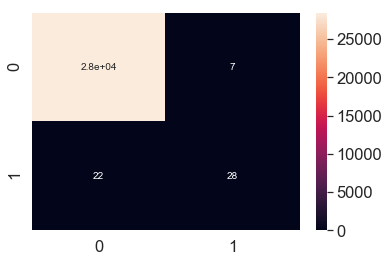

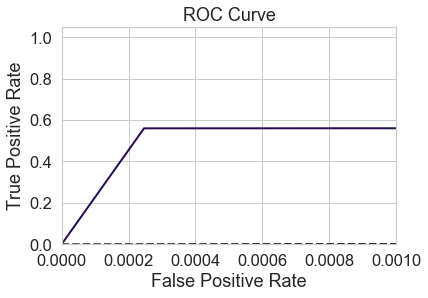

In [27]:
print(' Logistic Regression')
print('----------------------')


model = LogisticRegression()
model.fit(x_train, y_train)
pred = model.predict(x_test)
print('Model Score:', +.score(x_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

con = confusion_matrix(y_test, pred)
sns.heatmap(con, annot=True)
plt.show()

plot_roc()

In [ ]:
# Find the best parameters : recall optimisation
from sklearn.model_selection import GridSearchCV
param_grid = {
            'penalty' : ['l1','l2'], 
            'class_weight' : ['balanced', None], 
            'C' : [0.1, 1, 10]
            }

In [ ]:
CV_log_cfl = GridSearchCV(estimator = model, param_grid = param_grid , scoring = 'recall', verbose = 1, n_jobs = -1)
CV_log_cfl.fit(x_train, y_train)

In [31]:
best_parameters = CV_log_cfl.best_params_
print('The best parameters for using this model is', best_parameters)

The best parameters for using this model is {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}


Model Score: 0.978160879182613
ROC_AUC_Score 0.9690964088494953
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     28431
           1       0.07      0.96      0.13        50

   micro avg       0.98      0.98      0.98     28481
   macro avg       0.54      0.97      0.56     28481
weighted avg       1.00      0.98      0.99     28481



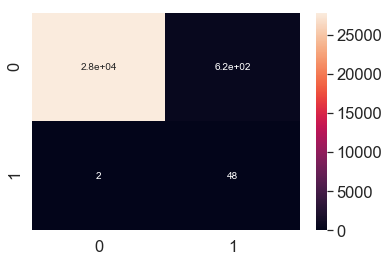

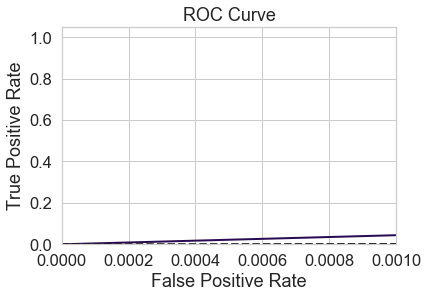

In [33]:
model = LogisticRegression(C = best_parameters['C'], 
                             penalty = best_parameters['penalty'], 
                             class_weight = best_parameters['class_weight'])
model.fit(x_train, y_train)
pred = model.predict(x_test)
print('Model Score:', model.score(x_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

con = confusion_matrix(y_test, pred)
sns.heatmap(con, annot=True)
plt.show()

plot_roc()

 Random Forest
------------------
Model Score: 0.9995786664794073
ROC_AUC_Score 0.9099472406879813
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28431
           1       0.93      0.82      0.87        50

   micro avg       1.00      1.00      1.00     28481
   macro avg       0.97      0.91      0.94     28481
weighted avg       1.00      1.00      1.00     28481



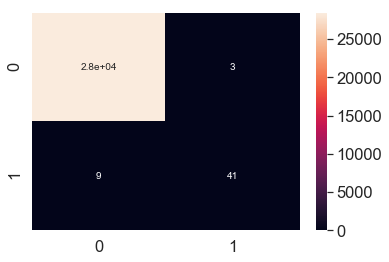

In [36]:
print(' Random Forest')
print('------------------')


rf_cfl = RandomForestClassifier()
rf_cfl.fit(x_train, y_train)
pred = model.predict(x_test)
print('Model Score:', model.score(x_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

con = confusion_matrix(y_test, pred)
sns.heatmap(con, annot=True)
plt.show()

In [38]:
param_grid = {
            'n_estimators': [200, 500],
            'max_features': [2, 3],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10]
            }

CV_rnd_cfl = GridSearchCV(estimator = rf_cfl, param_grid = param_grid, scoring = 'f1', verbose = 10, n_jobs = -1)
CV_rnd_cfl.fit(x_train, y_train)

best_parameters = CV_rf_cfl.best_params_
print("The best parameters for using this model is", best_parameters)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 17.6min


KeyboardInterrupt: 

Under- and Oversampling

To increase the model quality we will test different methods to balance the classes. Firstly, an under-sampler that reduces the larger class until it reaches the size of the smaller class, and secondly, an oversampler that generates data for the smaller class so that it reaches the size of the larger class. 

We also use the SMOTEEN algorithm, which is a hybrid of both methods.

As you can see, the model is mainly improved by oversampling. Here we already achieve a good accuracy with a simple model. Especially the recall values are good, which means that we have few false negatives, which we want to avoid.

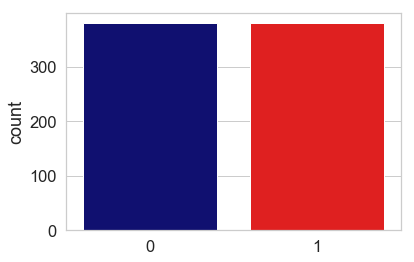

In [12]:
from imblearn.under_sampling import RandomUnderSampler

x = data.drop(["Class"], axis = 1)
y = data["Class"]

x_train, x_test, y_train, y_test = train_test_split(x,y)

rus = RandomUnderSampler(return_indices=True)
x_train, y_train, id_rus = rus.fit_sample(x_train, y_train)

sns.countplot(y_train, palette=my_pal)
plt.show()

Model Score: 0.9686104322912278
ROC_AUC_Score 0.9352507133814281
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71090
           1       0.04      0.90      0.08       112

   micro avg       0.97      0.97      0.97     71202
   macro avg       0.52      0.94      0.53     71202
weighted avg       1.00      0.97      0.98     71202



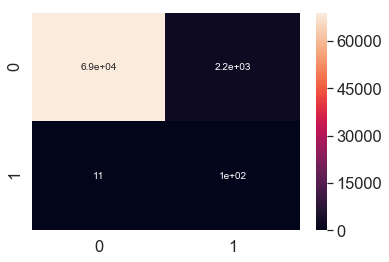

In [13]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)
print('Model Score:', model.score(x_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

con = confusion_matrix(y_test, pred)
sns.heatmap(con, annot=True)
plt.show()

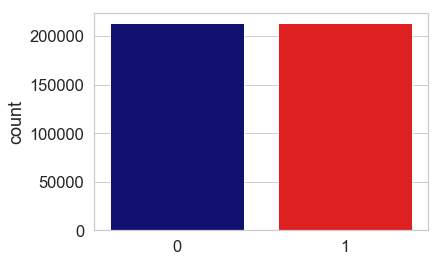

In [23]:
from imblearn.over_sampling import RandomOverSampler

x = data.drop(["Class"], axis = 1)
y = data["Class"]

x_train, x_test, y_train, y_test = train_test_split(x,y)

ros = RandomOverSampler()
x_train, y_train = ros.fit_sample(x_train, y_train)

sns.countplot(y_train, palette=my_pal)
plt.show()

Model Score: 0.9994241734782731
ROC_AUC_Score 0.8922162357565891
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71072
           1       0.89      0.78      0.83       130

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.94      0.89      0.92     71202
weighted avg       1.00      1.00      1.00     71202



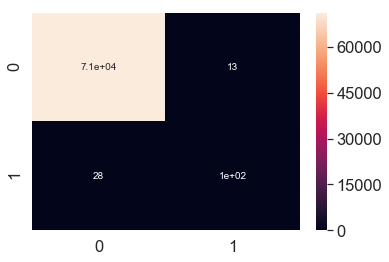

In [24]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)
print('Model Score:', model.score(x_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

con = confusion_matrix(y_test, pred)
sns.heatmap(con, annot=True)
plt.show()

Model Score: 0.9993539507317211
ROC_AUC_Score 0.8681326340195915
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71073
           1       0.89      0.74      0.81       129

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.94      0.87      0.90     71202
weighted avg       1.00      1.00      1.00     71202



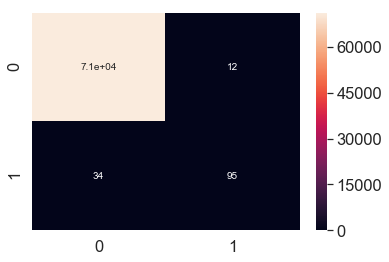

In [26]:
x = data.drop(["Class"], axis = 1)
y = data["Class"]

x_train, x_test, y_train, y_test = train_test_split(x,y)

sm = SMOTE(random_state=0)
x_train, y_train = sm.fit_sample(x_train, y_train)

model = RandomForestClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)
print('Model Score:', model.score(x_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

con = confusion_matrix(y_test, pred)
sns.heatmap(con, annot=True)
plt.show()

Model Score: 0.9995505744220669
ROC_AUC_Score 0.918711978977858
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71085
           1       0.88      0.84      0.86       117

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.94      0.92      0.93     71202
weighted avg       1.00      1.00      1.00     71202



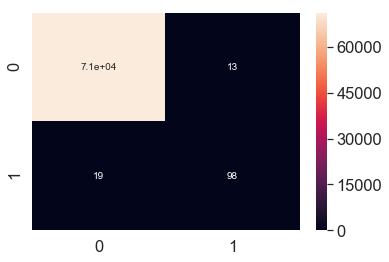

In [27]:
from imblearn.combine import SMOTEENN

x = data.drop(["Class"], axis = 1)
y = data["Class"]

x_train, x_test, y_train, y_test = train_test_split(x,y)

sm = SMOTEENN(random_state=0)
x_train, y_train = sm.fit_sample(x_train, y_train)

model = RandomForestClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)
print('Model Score:', model.score(x_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

con = confusion_matrix(y_test, pred)
sns.heatmap(con, annot=True)
plt.show()

# Resampling

in this we will resample our data with different size

then we will try to use this resampled data to train our model

then we will use this model to predict for our original data

In [ ]:
# for undersampling we need a portion of majority class and will take whole data of minority class
# count fraud transaction is the total number of fraud transaction
# now lets us see the index of fraud cases
fraud_indices = np.array(data[data.Class == 1].index)
normal_indices = np.array(data[data.Class == 0].index)

In [ ]:
# now let us a define a function for make undersample data with different proportion
# different proportion means with different proportion of normal classes of data


def generatePerformanceReport(clf,X_train,y_train,X_test,y_test,bool_):
    if bool_==True:
        clf.fit(X_train,y_train.values.ravel())
    pred=clf.predict(X_test)
    cnf_matrix=confusion_matrix(y_test,pred)
    tn, fp, fn, tp=cnf_matrix.ravel()
    print('---------------------------------')
    print('Length of training data:',len(X_train))
    print('Length of test data:', len(X_test))
    print('---------------------------------')
    print('True positives:',tp)
    print('True negatives:',tn)
    print('False positives:',fp)
    print('False negatives:',fn)
    #sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    print('----------------------Classification report--------------------------')
    print(classification_report(y_test,pred))
    

In [ ]:
# generate 50%, 66%, 75% proportions of normal indices to be combined with fraud indices
# undersampled data
normal_indices = data[data['Class'] == 0].index
fraud_indices = data[data['Class'] == 1].index
for i in range(1, 4):
    normal_sampled_data = np.array(np.random.choice(
        normal_indices, i*len(fraud_indices), replace=False))
    undersampled_data = np.concatenate([fraud_indices, normal_sampled_data])
    undersampled_data = data.iloc[undersampled_data]
    print('length of undersampled data ', len(undersampled_data))
    print('% of fraud transactions in undersampled data ', len(
        undersampled_data.loc[undersampled_data['Class'] == 1])/len(undersampled_data))
    # get feature and label data
    feature_data = undersampled_data.loc[:,
                                         undersampled_data.columns != 'Class']
    label_data = undersampled_data.loc[:, undersampled_data.columns == 'Class']
    X_train, X_test, y_train, y_test = train_test_split(
        feature_data, label_data, test_size=0.30)
    for j in [LogisticRegression(), SVC(), RandomForestClassifier(n_estimators=100)]:
        clf = j
        print(j)
        generatePerformanceReport(clf, X_train, y_train, X_test, y_test, True)
        # the above code classifies X_test which is part of undersampled data
        # now, let us consider the remaining rows of dataset and use that as test set
        remaining_indices = [
            i for i in data.index if i not in undersampled_data.index]
        testdf = data.iloc[remaining_indices]
        testdf_label = data.loc[:, testdf.columns == 'Class']
        testdf_feature = data.loc[:, testdf.columns != 'Class']
        generatePerformanceReport(
            clf, X_train, y_train, testdf_feature, testdf_label, False)

In [ ]:
#oversampled_data data
normal_sampled_indices=data.loc[data['Class']==0].index
oversampled_data=data.iloc[normal_sampled_indices]
fraud_data=data.loc[data['Class']==1]
oversampled_data=oversampled_data.append([fraud_data]*300, ignore_index=True)
print('length of oversampled_data data ', len(oversampled_data))
print('% of fraud transactions in oversampled_data data ',len(oversampled_data.loc[oversampled_data['Class']==1])/len(oversampled_data))
#get feature and label data
feature_data=oversampled_data.loc[:,oversampled_data.columns!='Class']
label_data=oversampled_data.loc[:,oversampled_data.columns=='Class']
X_train, X_test, y_train, y_test=train_test_split(feature_data,label_data,test_size=0.30)
for j in [LogisticRegression(),RandomForestClassifier(n_estimators=100)]:
    clf=j
    print(j)
    generatePerformanceReport(clf,X_train,y_train,X_test,y_test,True)
    #the above code classifies X_test which is part of undersampled data
    #now, let us consider the remaining rows of dataset and use that as test set
    remaining_indices=[i for i in data.index  if i not in oversampled_data.index]
    testdf=data.iloc[remaining_indices]
    testdf_label=data.loc[:,testdf.columns=='Class']
    testdf_feature=data.loc[:,testdf.columns!='Class']
    generatePerformanceReport(clf,X_train,y_train,testdf_feature,testdf_label,False)

# <a id='5'>5. Logistic Regression (LOG)</a>

##  <a id='5.1'>5.1. LOG - Without hyperparameters tuning</a>

In [ ]:
normal_indices=data[data['Class']==0].index
fraud_indices=data[data['Class']==1].index
for i in range(1,4):
    normal_sampled_data=np.array(np.random.choice(normal_indices, i*len(fraud_indices),replace=False))
    undersampled_data=np.concatenate([fraud_indices, normal_sampled_data])
    undersampled_data=data.iloc[undersampled_data]
    print('length of undersampled data ', len(undersampled_data))
    print('% of fraud transactions in undersampled data ',len(undersampled_data.loc[undersampled_data['Class']==1])/len(undersampled_data))
    #get feature and label data
    feature_data=undersampled_data.loc[:,undersampled_data.columns!='Class']
    label_data=undersampled_data.loc[:,undersampled_data.columns=='Class']
    X_train, X_test, y_train, y_test=train_test_split(feature_data,label_data,test_size=0.30)
    for j in [LogisticRegression(),SVC(),RandomForestClassifier(n_estimators=100)]:
        clf=j
        print(j)
        generatePerformanceReport(clf,X_train,y_train,X_test,y_test,True)
        #the above code classifies X_test which is part of undersampled data
        #now, let us consider the remaining rows of dataset and use that as test set
        remaining_indices=[i for i in creditcard_data.index  if i not in undersampled_data.index]
        testdf=creditcard_data.iloc[remaining_indices]
        testdf_label=creditcard_data.loc[:,testdf.columns=='Class']
        testdf_feature=creditcard_data.loc[:,testdf.columns!='Class']
        generatePerformanceReport(clf,X_train,y_train,testdf_feature,testdf_label,False)

In [ ]:
# Show parameters currently use
from pprint import pprint
print('Parameters currently in use:\n')
pprint(log_cfl.get_params())

##  <a id='5.2'>5.2. LOG - Grid Search CV to optimise Recall</a>

In [ ]:
# Find the best parameters : recall optimisation
from sklearn.model_selection import GridSearchCV
param_grid = {
            'penalty' : ['l1','l2'], 
            'class_weight' : ['balanced', None], 
            'C' : [0.1, 1, 10, 100]
            }

CV_log_cfl = GridSearchCV(estimator = log_cfl, param_grid = param_grid , scoring = 'recall', verbose = 1, n_jobs = -1)
CV_log_cfl.fit(X_train, y_train)

best_parameters = CV_log_cfl.best_params_
print('The best parameters for using this model is', best_parameters)

## <a id='5.3'>5.3. LOG - With best hyperparameters</a>

In [ ]:
#Logistic regression with the best parameters
log_cfl = LogisticRegression(C = best_parameters['C'], 
                             penalty = best_parameters['penalty'], 
                             class_weight = best_parameters['class_weight'])

log_cfl.fit(X_train, y_train)
y_pred = log_cfl.predict(X_test)
y_score = log_cfl.decision_function(X_test)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='LOG Confusion matrix')

plt.savefig('4.log_cfl_confusion_matrix.png')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

fpr_log, tpr_log, t_log = fpr, tpr, t
precision_log, recall_log, thresholds_log = precision, recall, thresholds

# <a id='6'>6. Extreme Gradient Boosting (XGB)</a>

## <a id='6.1'>6.1. XGB - Without hyperparameters tuning</a>

In [ ]:
# xgb
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)

xgb_cfl.fit(X_train, y_train)
y_pred = xgb_cfl.predict(X_test)
y_score = xgb_cfl.predict_proba(X_test)[:,1]

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='XGB Confusion matrix')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

## <a id='6.2'>6.2. XGB - Grid Search CV to find best n_estimators (F1_score)</a>

Grid search CV is really slow, you can add or remove some hyperparameters (or use early_stop) : 

    param_grid = {
                'n_estimators': [100, 200, 300, 400]
                  }

    CV_xgb_cfl = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid, scoring ='f1', verbose = 2)
    CV_xgb_cfl.fit(X_train, y_train)

    best_parameters = CV_xgb_cfl.best_params_
    print("The best parameters for using this model is", best_parameters)

![](https://image.noelshack.com/fichiers/2018/20/6/1526746266-ok.png)

## <a id='6.3'>6.3. XGB - With best hyperparameters</a>

In [ ]:
# xgb
xgb_cfl = xgb.XGBClassifier(n_jobs = -1, 
                            n_estimators = 200)

xgb_cfl.fit(X_train, y_train)
y_pred = xgb_cfl.predict(X_test)
y_score = xgb_cfl.predict_proba(X_test)[:,1]

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'XGB Confusion matrix')
plt.savefig('2.xgb_cfl_confusion_matrix.png')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

fpr_xgb, tpr_xgb, t_xgb = fpr, tpr, t
precision_xgb, recall_xgb, thresholds_xgb = precision, recall, thresholds

In [ ]:
plot_feature_importance(xgb_cfl)

# <a id='7'>7. Random Forest (RF)</a>

## <a id='7.1'>7.1. RF - Without hyperparameters tuning</a>

In [ ]:
# Ramdom forest Classifier
rf_cfl = RandomForestClassifier(n_jobs = -1,
                                random_state = 42)

rf_cfl.fit(X_train, y_train)
y_pred = rf_cfl.predict(X_test)
y_score = rf_cfl.predict_proba(X_test)[:,1]

# Confusion maxtrix
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'RF Confusion matrix')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

## <a id='7.2'>7.2. RF - Grid Search CV to optimise F1_score</a>

Grid search CV is really slow, you can add or remove some parameters  : 

    from sklearn.model_selection import GridSearchCV

    param_grid = {
                'n_estimators': [100, 200, 500],
                'max_features': [2, 3],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 10]
                }

    CV_rnd_cfl = GridSearchCV(estimator = rf_cfl, param_grid = param_grid, scoring = 'f1', verbose = 10, n_jobs = -1)
    CV_rnd_cfl.fit(X_train, y_train)

    best_parameters = CV_rf_cfl.best_params_
    print("The best parameters for using this model is", best_parameters)

![](https://image.noelshack.com/fichiers/2018/20/5/1526651240-gridcv-rnd.png)

## <a id='7.3'>7.3. RF - With best hyperparameters</a>

In [ ]:
# Ramdom forest Classifier
rf_cfl = RandomForestClassifier(n_estimators = 200, 
                                 max_features = 3, 
                                 min_samples_leaf = 1, 
                                 min_samples_split = 2, 
                                 n_jobs = -1,
                                random_state = 42)

rf_cfl.fit(X_train, y_train)
y_pred = rf_cfl.predict(X_test)
y_score = rf_cfl.predict_proba(X_test)[:,1]

# Confusion maxtrix
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'RF Confusion matrix')
plt.savefig('3.rf_cfl_confusion_matrix.png')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

fpr_rf, tpr_rf, t_rf = fpr, tpr, t
precision_rf, recall_rf, thresholds_rf = precision, recall, thresholds

In [ ]:
plot_feature_importance(rf_cfl)

In [ ]:
# def X and Y
y = np.array(data.Class.tolist())
data = data.drop('Class', 1)
X = np.array(data.as_matrix())

# <a id='8'>8. VotingClassifier = LOG - XGB - RND (F1 = 0.881)</a>

## <a href='#paeed'>8.1. VotingClassifier</a>

In [ ]:
#Voting Classifier
voting_cfl = VotingClassifier (
        estimators = [('xgb', xgb_cfl), ('lt', log_cfl), ('rf', rf_cfl)],
                     voting='soft', weights = [1, 1, 1.33])
    
voting_cfl.fit(X_train,y_train)

y_pred = voting_cfl.predict(X_test)
y_score = voting_cfl.predict_proba(X_test)[:,1]

# Confusion maxtrix
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'VOTING Confusion matrix')
plt.savefig('1.voting_confusion_matrix.png')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

fpr_voting, tpr_voting, t_voting = fpr, tpr, t
precision_voting, recall_voting, thresholds_voting = precision, recall, thresholds

## <a id='8.2'>8.2. Precision - Recall – Threshold Curve</a>

In [ ]:
pr = 0.937
rec = 0.831
t = 0.5

In [ ]:
# Precision-recall-threshold curve : 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(16, 12))
    plt.title('Precision and Recall Scores (decision threshold)')
    plt.plot(thresholds, precisions[:-1], 'b-',linewidth=2, label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g', linewidth=2, label='Recall')
    plt.axvline(t, color='k', linestyle='--', label='Threshold')
    plt.axhline(pr, color='blue', linewidth=2, linestyle='--')
    plt.axhline(rec, color='green', linewidth=2, linestyle='--')
    plt.ylabel('Score')
    plt.xlabel('Decision Threshold')
    plt.legend(loc='best')
    plt.savefig('5.prec_recc_threshold.png')
    plt.show();

In [ ]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)



cf. part 9.3 : select the best threshold

## <a id='8.3'>8.3. Compare ROC Curves (all models)</a>

In [ ]:
def roc_curve_all_models () : 
    plt.figure(figsize=(16, 12))
    plt.plot(fpr_rf, tpr_rf, label = 'ROC curve', linewidth = 2)
    plt.plot(fpr_xgb, tpr_xgb, label = 'ROC curve', linewidth = 2)
    plt.plot(fpr_log, tpr_log, label = 'ROC curve', linewidth = 2)
    plt.plot(fpr_voting, tpr_voting, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(['Rnd','Xgb', 'Log', 'Voting'], loc='upper left')
    plt.savefig('6.roc.png')
    plt.show();

In [ ]:
roc_curve_all_models ()

## <a id='8.4'>8.4. Compare Precision - Recall Curves (all models)</a>

In [ ]:
def prec_recall_all_models () :
    plt.figure(figsize=(16, 12))
    plt.plot(recall_rf, precision_rf, linewidth = 2)
    plt.plot(recall_xgb, precision_xgb, linewidth = 2)
    plt.plot(recall_log, precision_log, linewidth = 2)
    plt.plot(recall_voting, precision_voting, linewidth = 2)
    plt.scatter(rec, pr, linewidth = 2, color = 'red')
    plt.axvline(rec, color = 'red', linewidth = 1, linestyle='--')
    plt.axhline(pr, color = 'red', linewidth = 1, linestyle='--')
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve - PR = 0.937 - REC = 0.831 - F1 = 881 ')
    plt.legend(['Rnd', 'Xgb', 'Log', 'Voting'], loc='upper right')
    plt.savefig('7.prec_recc.png')
    plt.show();

In [ ]:
prec_recall_all_models () 

# <a id='9'>9. VotingClassifier : Validation (F1 = 0.884)</a>

dataset = valid_data 

## <a id='9.1'>9.1. Normalize Amount, drop useless variables and define (X, y)</a>    

In [ ]:
# Normalize amount in valid_data 'normAmount' 
from sklearn.preprocessing import StandardScaler
valid_data['normAmount'] = StandardScaler().fit_transform(valid_data['Amount'].values.reshape(-1,1))

In [ ]:
# Drop time and amount in valid_data
valid_data = valid_data.drop(['Amount','Time'],axis=1)

In [ ]:
# Define X & y
y = np.array(valid_data.Class.tolist())
valid_data = valid_data.drop('Class', 1)
X = np.array(valid_data.as_matrix())

## <a href='#5-15-1'>9.2. VotingClassifier on valid_data (trained & tested in 8.1.)</a>

In [ ]:
# Apply voting_classifier, previously trained, on valid_data : 
y_pred = voting_cfl.predict(X)
y_score = voting_cfl.predict_proba(X)[:,1]

In [ ]:
# Metrics valid_data
# Confusion Matrix 
cm = confusion_matrix(y, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'VOTING valid Confusion matrix')
plt.savefig('8.votingvf_cfl_confusion_matrix.png')
plt.show()

show_metrics()

#ROC
fpr, tpr, t = roc_curve(y, y_score)
plot_roc()

#precision recall
precision, recall, thresholds = precision_recall_curve(y, y_score)
plot_precision_recall()

## <a href='#5-15-2'>9.3. Threshold selection</a>

![](https://image.noelshack.com/fichiers/2018/21/1/1526914109-ok-thresh.png)
source : http://www.prolekare.cz/en/journal-of-czech-physicians-article/roc-analysis-and-the-use-of-cost-benefit-analysis-for-determination-of-the-optimal-cut-point-5403?confirm_rules=1

In [ ]:
thresholds_adj = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize = (15,15))

j = 1
for i in thresholds_adj:
    y_score = voting_cfl.predict_proba(X)[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = confusion_matrix(y, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    print('F1_score w/ threshold = %s :'%i, (2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))
    
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i) 
    
plt.savefig('9.confusion_matrix_thresold_select.png')

The best compromise is the threshold = 0.5 (standard)

# Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
data['normalizedAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Amount'],axis=1)

In [ ]:
data = data.drop(['Time'],axis=1)
data.head()

In [ ]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [ ]:
X.info()

In [ ]:
y.head()

# Model Training

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state=101)

In [ ]:
# Decison Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

classifier = DecisionTreeClassifier(criterion = 'gini',  splitter='best', min_samples_leaf=1, min_samples_split=2)
classifier.fit(X_train, y_train)

          

In [ ]:
# Predicting Test Set
y_predicitons = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_predicitons)
precision = precision_score(y_test, y_predicitons)
recall = recall_score(y_test, y_predicitons)
f1 = f1_score(y_test, y_predicitons)


results = pd.DataFrame([['Decision tree', accuracy, precision, recall, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [ ]:
results

In [ ]:
# Randomforest
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
classifier.fit(X_train, y_train)

In [ ]:
# Predicting Test Set
y_predicitons_rf = classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_predicitons_rf)
precision_rf = precision_score(y_test, y_predicitons_rf)
recall_rf = recall_score(y_test, y_predicitons_rf)
f1_rf = f1_score(y_test, y_predicitons_rf)


model_results = pd.DataFrame([['Random Forest', accuracy_rf, precision_rf, recall_rf, f1_rf]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)

In [ ]:
results

# Artifial Neural Network Model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units =15 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 29))

# Adding the second hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 32, epochs = 33, verbose=2)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)


In [ ]:
score = classifier.evaluate(X_test, y_test)
score

In [ ]:

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)




In [ ]:
cm

In [ ]:
#Let's see how our model performed
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
## EXTRA: Confusion Matrix
cm = confusion_matrix(y_test, y_pred) # rows = truth, cols = prediction
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))